# Importing required libraries 

In [1]:
from kiteconnect import KiteConnect,KiteTicker
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import os 
import time
from time import sleep 
from pyotp import TOTP
from datetime import datetime
from urllib.parse import urlparse,parse_qs
import pandas as pd 
import numpy as np
import seaborn as sns 
import datetime as dt
import matplotlib.pyplot as plt
import sys
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
import plotly.graph_objects as go
from datetime import timedelta
import mplfinance as mpf
import torch 
from torch import nn
from torch.utils.data import Dataset,DataLoader,random_split
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [2]:
def get_curr_path(folder_name):
    curr_dir = os.getcwd()
    curr_path = os.path.join(curr_dir,folder_name)
    return curr_path

def get_credentials(curr_path,file_name):
    file_dir = os.path.join(curr_path,file_name)
    file = open(file_dir,'r').read().split()
    api_key = file[0]
    api_secret = file[1]
    user_name = file[2]
    pwd = file[3]
    totp_key = file[-1]
    return api_key,api_secret,user_name,pwd,totp_key

def auto_login(api_key,user_name,pwd,totp_key):
    kite = KiteConnect(api_key=api_key)
    service = Service(ChromeDriverManager().install())
    service.start()
    options = Options()
    options.to_capabilities()
    driver = webdriver.Remote(
        command_executor=service.service_url,
        options=options)
    driver.get(kite.login_url())
    driver.implicitly_wait(5)
    username = driver.find_element(By.XPATH, "//input[@type='text']")
    username.send_keys(user_name)
    password = driver.find_element(By.XPATH, "//input[@type='password']")
    password.send_keys(pwd)
    driver.find_element(By.XPATH, "//button[@type='submit']").click()
    sleep(1)
    totp = driver.find_element(By.XPATH,"//input[@type='number']")
    totp_token = TOTP(totp_key)
    token = totp_token.now()
    totp.send_keys(token)
    driver.find_element(By.XPATH,"//button[@type = 'submit']").click()
    sleep(1)
    current_url = driver.current_url
    parsed_url = urlparse(current_url)
    query_params = parse_qs(parsed_url.query)
    request_token = query_params.get('request_token',[None])[0]
    with open('request_token.txt', 'w') as f:
        f.write(request_token)
    request_token = open('request_token.txt','r').read()
    driver.quit()
    return request_token
    

def generate_access_token(request_token,api_key,api_secret):
    request_token = open('request_token.txt','r').read()
    kite = KiteConnect(api_key=api_key)
    data = kite.generate_session(request_token=request_token,api_secret=api_secret)
    data
    with open('access_token.txt','w') as f:
        f.write(data['access_token'])
    access_token = open('access_token.txt','r').read()
    return access_token

# Automating the login in zerodha 

In [3]:
folder_name = 'api_keys'
curr_dir = get_curr_path(folder_name)

file_name = 'credentials.txt'
api_key,api_secret,user_name,pwd,totp_key = get_credentials(curr_dir,file_name)

request_token = auto_login(api_key,user_name,pwd,totp_key)

access_token = generate_access_token(request_token,api_key,api_secret)

# Setting up the access token to execute buy,sell orders

In [4]:
kite = KiteConnect(api_key=api_key)
kite.set_access_token(access_token=access_token)

In [5]:
instrument_dump = kite.instruments('NSE')
instrument_df = pd.DataFrame(instrument_dump)
instrument_df.to_csv('NSE_instruments.csv',index=False)

In [6]:
def tokenLookup(instrument_df,symbol_list):
    """Looks up instrument token for a given script from instrument dump"""
    token_list = []
    for symbol in symbol_list:
        token_list.append(int(instrument_df[instrument_df.tradingsymbol==symbol].instrument_token.values[0]))
    return token_list

def tickerLookup(token):
    global instrument_df
    return instrument_df[instrument_df.instrument_token==token].tradingsymbol.values[0] 

def instrumentLookup(instrument_df,symbol):
    """Looks up instrument token for a given script from instrument dump"""
    try:
        return instrument_df[instrument_df.tradingsymbol==symbol].instrument_token.values[0]
    except:
        return -1

def fetchOHLC(ticker,interval,duration):
    """extracts historical data and outputs in the form of dataframe"""
    instrument = instrumentLookup(instrument_df,ticker)
    data = pd.DataFrame(kite.historical_data(instrument,dt.date.today()-dt.timedelta(duration), dt.date.today(),interval))
    data.set_index("date",inplace=True)
    return data

def fetchOHLCExtended(ticker, inception_date, interval):
    """Extracts historical data and outputs in the form of a DataFrame.
       inception_date string format - dd-mm-yyyy"""
    instrument = instrumentLookup(instrument_df, ticker)
    from_date = dt.datetime.strptime(inception_date, '%d-%m-%Y')
    data = pd.DataFrame()  # Start with an empty DataFrame
    while True:
        if from_date.date() >= (dt.date.today() - dt.timedelta(100)):
            new_data = pd.DataFrame(kite.historical_data(instrument, from_date, dt.date.today(), interval))
            if not new_data.empty:
                if data.empty:
                    data = new_data
                else:
                    data = pd.concat([data, new_data], ignore_index=True)
            break
        else:
            to_date = from_date + dt.timedelta(100)
            new_data = pd.DataFrame(kite.historical_data(instrument, from_date, to_date, interval))
            if not new_data.empty:
                if data.empty:
                    data = new_data
                else:
                    data = pd.concat([data, new_data], ignore_index=True)
            from_date = to_date
    
    if not data.empty:
        data.set_index("date", inplace=True)
    return data



# Extracting daily data of infosys stock

In [7]:
ohlc = fetchOHLCExtended("INFY", "31-12-2022", 'day')

In [8]:
print(ohlc.shape)
ohlc.head()

(385, 5)


,open,high,low,close,volume
date,,,,,
2023-01-02 00:00:00+05:30,1514.00,1526.50,1504.05,1524.00,3801140
2023-01-03 00:00:00+05:30,1519.85,1532.65,1515.10,1522.55,4551130
2023-01-04 00:00:00+05:30,1521.00,1521.00,1491.10,1494.80,7059590
2023-01-05 00:00:00+05:30,1505.90,1505.90,1469.25,1475.20,9868404
2023-01-06 00:00:00+05:30,1470.00,1475.00,1446.50,1448.50,6443714


# Computing the technical indicators 

In [9]:
temp_df = ohlc.copy()
temp_df.head()

,open,high,low,close,volume
date,,,,,
2023-01-02 00:00:00+05:30,1514.00,1526.50,1504.05,1524.00,3801140
2023-01-03 00:00:00+05:30,1519.85,1532.65,1515.10,1522.55,4551130
2023-01-04 00:00:00+05:30,1521.00,1521.00,1491.10,1494.80,7059590
2023-01-05 00:00:00+05:30,1505.90,1505.90,1469.25,1475.20,9868404
2023-01-06 00:00:00+05:30,1470.00,1475.00,1446.50,1448.50,6443714


In [10]:
signals_df = temp_df.copy()

# Price Actions Concepts 
<ol>
    <li>Buliish signals: Bullish Engulfing and Hammer candlesticks</li>
    <li>Bearish signals: Bearish Engulfing and Shooting Star candlesticks</li>
    <li>Support and Resistance Levels</li>
</ol>

Hammer candlesticks

In [11]:
def hammer(df):    
    """returns dataframe with hammer candle column"""
    df = df.copy()
    df["hammer"] = ((((df["high"] - df["low"])>3*(df["open"] - df["close"])) & \
                   ((df["close"] - df["low"])/(.001 + df["high"] - df["low"]) > 0.6) & \
                   ((df["open"] - df["low"])/(.001 + df["high"] - df["low"]) > 0.6)) & \
                   (abs(df["close"] - df["open"]) > 0.1* (df["high"] - df["low"]))).astype(int)
    return df

In [12]:
signals_df = hammer(signals_df)

In [13]:
signals_df[signals_df['hammer'] == 1].head()

,open,high,low,close,volume,hammer
date,,,,,,
2023-02-10 00:00:00+05:30,1612.95,1616.30,1596.45,1608.55,4786762,1
2023-03-08 00:00:00+05:30,1490.55,1496.00,1481.10,1492.70,4137080,1
2023-04-17 00:00:00+05:30,1250.30,1261.15,1185.30,1258.30,53171705,1
2023-04-24 00:00:00+05:30,1228.00,1230.00,1218.00,1226.30,8313774,1
2023-06-27 00:00:00+05:30,1280.00,1282.00,1274.20,1279.15,3240024,1


Shooting star candlesticks

In [14]:
def shooting_star(df):    
    """returns dataframe with shooting star candle column"""
    df = df.copy()
    df["shooting_star"] = ((((df["high"] - df["low"])>3*(df["open"] - df["close"])) & \
                   ((df["high"] - df["close"])/(.001 + df["high"] - df["low"]) > 0.6) & \
                   ((df["high"] - df["open"])/(.001 + df["high"] - df["low"]) > 0.6)) & \
                   (abs(df["close"] - df["open"]) > 0.1* (df["high"] - df["low"]))).astype(int)
    return df

In [15]:
signals_df = shooting_star(signals_df)

In [16]:
signals_df[signals_df['shooting_star'] == 1].tail()

,open,high,low,close,volume,hammer,shooting_star
date,,,,,,,
2024-05-06 00:00:00+05:30,1420.00,1445.7,1417.10,1425.90,6445422,0,1
2024-05-18 00:00:00+05:30,1445.00,1450.0,1442.00,1443.65,318277,0,1
2024-05-21 00:00:00+05:30,1430.00,1444.7,1428.40,1434.15,6752663,0,1
2024-06-18 00:00:00+05:30,1497.00,1507.0,1495.40,1498.20,5420939,0,1
2024-06-28 00:00:00+05:30,1572.55,1588.5,1564.25,1566.75,8197544,0,1


Bullish Engulfing and Bearish Engulfing 

In [17]:
def engulfing_signal(df):
    df = df.copy()
    length = len(df)
    high = list(df['high'])
    low = list(df['low'])
    close = list(df['close'])
    open = list(df['open'])
    signal = [0] * length # [0,1,2] 0: no engulfing, 1: bearish, 2: bullish
    bodydiff = [0] * length # abs diff of the close and opening 
    
    for row in range(1, length):
        bodydiff[row] = abs(open[row]-close[row])
        bodydiffmin = 0.003
        if (bodydiff[row]>bodydiffmin and bodydiff[row-1]>bodydiffmin and
            open[row-1]<close[row-1] and
            open[row]>close[row] and 
            #open[row]>=close[row-1] and close[row]<open[row-1]):
            (open[row]-close[row-1])>=+0e-5 and close[row]<open[row-1]):
            signal[row] = 1
        elif (bodydiff[row]>bodydiffmin and bodydiff[row-1]>bodydiffmin and
            open[row-1]>close[row-1] and
            open[row]<close[row] and 
            #open[row]<=close[row-1] and close[row]>open[row-1]):
            (open[row]-close[row-1])<=-0e-5 and close[row]>open[row-1]):
            signal[row] = 2
        else:
            signal[row] = 0
        #signal[row]=random.choice([0, 1, 2])
        #signal[row]=1
    return signal

# engulf_df['engulf_bullish_bearish'] = signal(engulf_df)

In [18]:
signals_df['bullish_bearish_engulfing'] = engulfing_signal(signals_df)

#bullish engulfing candles 
signals_df[signals_df['bullish_bearish_engulfing'] == 2].tail()

,open,high,low,close,volume,hammer,shooting_star,bullish_bearish_engulfing
date,,,,,,,,
2024-02-06 00:00:00+05:30,1686.75,1733.0,1673.95,1729.45,7694265,0,0,2
2024-03-12 00:00:00+05:30,1600.00,1625.0,1597.65,1612.95,4614222,0,0,2
2024-06-27 00:00:00+05:30,1538.45,1578.4,1532.05,1573.35,14757754,0,0,2
2024-07-01 00:00:00+05:30,1559.50,1599.9,1559.50,1590.80,6801771,0,0,2
2024-07-08 00:00:00+05:30,1643.10,1666.0,1640.00,1661.65,5880533,0,0,2


In [19]:
#bearish engulfing candles 
signals_df[signals_df['bullish_bearish_engulfing'] == 1].tail()

,open,high,low,close,volume,hammer,shooting_star,bullish_bearish_engulfing
date,,,,,,,,
2023-11-08 00:00:00+05:30,1405.00,1405.00,1386.45,1391.00,3550635,0,0,1
2023-12-01 00:00:00+05:30,1459.90,1459.90,1446.15,1452.30,3489187,0,0,1
2023-12-05 00:00:00+05:30,1465.80,1466.90,1442.00,1453.95,5123039,0,0,1
2024-01-20 00:00:00+05:30,1665.55,1669.25,1645.00,1648.85,1158144,0,0,1
2024-03-27 00:00:00+05:30,1496.00,1499.00,1481.55,1483.85,6857402,0,0,1


# Support and Resistance 

In [20]:
signals_df.to_csv('signals.csv')

Inferring the logic from <b>fractal candlestick patterns</b>  to identify the key levels

In [21]:
def find_support(df):
    df = df.copy()
    supports = df[df.low == df.low.rolling(5, center=True).min()].low
    return supports

def find_resistance(df):
    df = df.copy()
    resistance = df[df.high == df.high.rolling(5, center=True).max()].high
    return resistance

supports = find_support(signals_df)
resistances = find_resistance(signals_df)
print(supports[:5])
print(resistances[:5])


date
2023-01-06 00:00:00+05:30    1446.5
2023-01-20 00:00:00+05:30    1524.0
2023-01-27 00:00:00+05:30    1507.4
2023-02-07 00:00:00+05:30    1555.1
2023-02-13 00:00:00+05:30    1566.0
Name: low, dtype: float64
date
2023-01-18 00:00:00+05:30    1551.85
2023-01-24 00:00:00+05:30    1568.80
2023-02-03 00:00:00+05:30    1604.65
2023-02-09 00:00:00+05:30    1619.75
2023-02-16 00:00:00+05:30    1614.45
Name: high, dtype: float64


In [22]:
def find_sp_resistance_levels(supports,resistances):
    levels = pd.concat([supports,resistances])
    levels = levels.dropna().sort_index()
    return levels

levels = find_sp_resistance_levels(supports,resistances)
levels.head()

date
2023-01-06 00:00:00+05:30    1446.50
2023-01-18 00:00:00+05:30    1551.85
2023-01-20 00:00:00+05:30    1524.00
2023-01-24 00:00:00+05:30    1568.80
2023-01-27 00:00:00+05:30    1507.40
dtype: float64

In [23]:
len(levels)

110

In [24]:
s = np.mean(signals_df['high'] - signals_df['low']) 

In [25]:
def is_far_from_level(l,levels,s):
    return np.sum([abs(l - levels[i]) < s for i in range(len(levels))]) == 0


In [26]:
def masking_filter(levels):
    levels = levels.copy()
    filtered_levels = []
    corresponding_dates =  []
    for date,level in levels.items():
        if is_far_from_level(level,filtered_levels,s):
            filtered_levels.append(level)
            corresponding_dates.append(date)
    filtered_levels_df = pd.DataFrame(filtered_levels, columns=['level'], index=corresponding_dates)
    filtered_levels_df['type'] = ['support' if level in supports.values else 'resistance' for level in filtered_levels_df['level']]
    return filtered_levels_df

In [27]:
filtered_levels_df = masking_filter(levels)
print(filtered_levels_df)

                             level        type
2023-01-06 00:00:00+05:30  1446.50     support
2023-01-18 00:00:00+05:30  1551.85  resistance
2023-01-20 00:00:00+05:30  1524.00     support
2023-02-03 00:00:00+05:30  1604.65  resistance
2023-03-23 00:00:00+05:30  1370.00     support
2023-04-17 00:00:00+05:30  1185.30     support
2023-04-25 00:00:00+05:30  1215.00     support
2023-05-02 00:00:00+05:30  1279.75  resistance
2023-05-05 00:00:00+05:30  1254.25     support
2023-05-23 00:00:00+05:30  1314.15  resistance
2023-07-19 00:00:00+05:30  1498.80  resistance
2023-08-17 00:00:00+05:30  1420.00     support
2024-01-15 00:00:00+05:30  1664.95  resistance
2024-01-23 00:00:00+05:30  1637.70     support
2024-01-30 00:00:00+05:30  1690.00  resistance
2024-02-06 00:00:00+05:30  1733.00  resistance


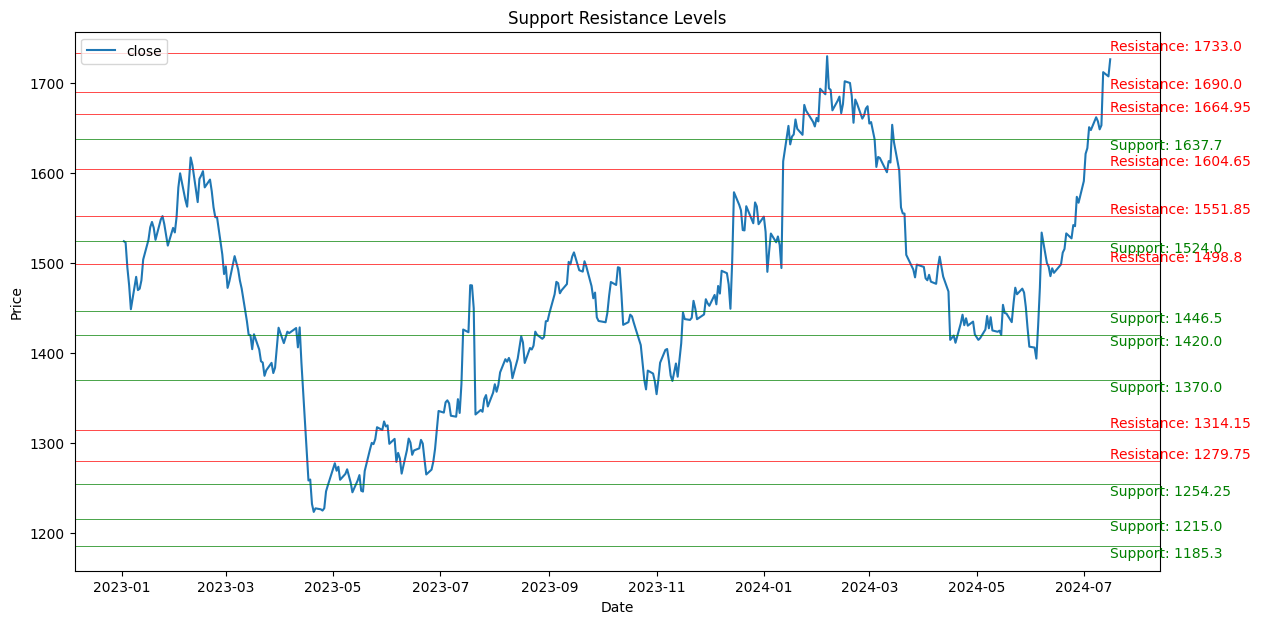

In [28]:
plt.figure(figsize=(14, 7))
plt.plot(signals_df.index, signals_df['close'], label='close')

for level in filtered_levels_df.itertuples():
    if level.type == 'support':
        plt.axhline(y=level.level, color='g', linestyle='-', linewidth=0.5)
        plt.text(signals_df.index[-1], level.level, f'Support: {level.level}', color='g', verticalalignment='top')
        # plt.hlines(y=level.level, xmin=signals_df.index[0], xmax=signals_df.index[-1], colors='g', linewidth=1.0, linestyle='-')
    elif level.type == 'resistance':
        plt.axhline(y=level.level, color='r', linestyle='-', linewidth=0.5)
        plt.text(signals_df.index[-1], level.level, f'Resistance: {level.level}', color='r', verticalalignment='bottom')
        # plt.hlines(y=level.level, xmin=signals_df.index[0], xmax=signals_df.index[-1], colors='r', linewidth=1.0, linestyle='-')

plt.legend()
plt.title('Support Resistance Levels')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

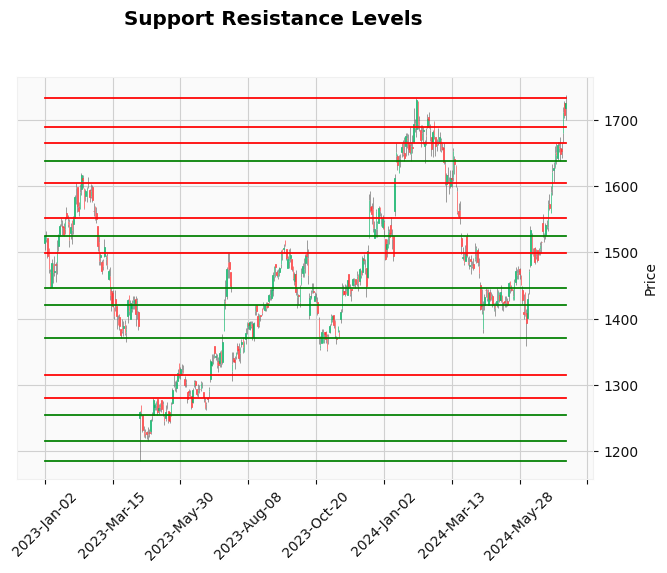

In [29]:
hline_levels = []
for level in filtered_levels_df.itertuples():
    color = 'g' if level.type == 'support' else 'r'
    hline_levels.append(mpf.make_addplot([level.level] * len(signals_df), color=color, linestyle='-'))

mpf.plot(signals_df, type='candle', addplot=hline_levels, style='yahoo', title='Support Resistance Levels', ylabel='Price')




In [30]:
filtered_levels_df

,level,type
2023-01-06 00:00:00+05:30,1446.50,support
2023-01-18 00:00:00+05:30,1551.85,resistance
2023-01-20 00:00:00+05:30,1524.00,support
2023-02-03 00:00:00+05:30,1604.65,resistance
2023-03-23 00:00:00+05:30,1370.00,support
2023-04-17 00:00:00+05:30,1185.30,support
2023-04-25 00:00:00+05:30,1215.00,support
2023-05-02 00:00:00+05:30,1279.75,resistance
2023-05-05 00:00:00+05:30,1254.25,support
2023-05-23 00:00:00+05:30,1314.15,resistance


# Visualising the buy sell points

In [31]:
def generate_buy_sell(df, filtered_levels_df, profit_percentage, loss_percentage, capital):
    df = df.copy()
    pos = False
    trades = []
    buy_price, stop_loss, take_profit, trailing_stop_loss, total_profit_loss = 0, 0, 0, 0, 0

    for i in range(len(df)):
        current_price = df['close'].iloc[i]

        nearest_support = None
        nearest_resistance = None
        for level in filtered_levels_df.itertuples():
            if level.type == 'support' and abs(level.level - current_price) / current_price < 0.02:
                nearest_support = level.level
            if level.type == 'resistance' and abs(level.level - current_price) / current_price < 0.02:
                nearest_resistance = level.level

        if not pos and nearest_support is not None:
            if (df['bullish_bearish_engulfing'].iloc[i] == 2 or df['hammer'].iloc[i] == 1):
                buy_price = current_price
                quantity = capital // buy_price
                if quantity == 0:
                    print(f"Insufficient capital to buy stocks at index {i}")
                    continue 
                total_buy_price = buy_price * quantity
                stop_loss = buy_price - (buy_price * (loss_percentage / 100))
                take_profit = buy_price + (buy_price * (profit_percentage / 100))
                trailing_stop_loss = buy_price - (buy_price * (loss_percentage / 100))
                buy_date = df.index[i]
                pos = True
                capital -= total_buy_price
                print(f"Buy Signal: price: {buy_price}, stop loss: {stop_loss}, take profit: {take_profit}, trailing stop loss: {trailing_stop_loss}, capital: {capital}, quantity: {quantity}, date: {df.index[i]}")

        if pos and nearest_resistance is not None:
            # Update trailing stop loss
            if current_price > buy_price * (1 + profit_percentage / 100):
                trailing_stop_loss = max(trailing_stop_loss, current_price - (current_price * (loss_percentage / 100)))

            # Exit condition for long position
            if (df['bullish_bearish_engulfing'].iloc[i] == 1 or df['shooting_star'].iloc[i] == 1) or \
               (current_price <= stop_loss) or (current_price >= take_profit) or (current_price <= trailing_stop_loss):
                sell_price = current_price
                total_sell_price = sell_price * quantity
                capital += total_sell_price
                profit_loss = (sell_price - buy_price) 
                total_profit_loss = total_sell_price - total_buy_price
                trades.append({
                    'buy_date': buy_date,
                    'buy_price': buy_price,
                    'target_profit': take_profit,
                    'stop_loss': stop_loss,
                    'total_buy_price': total_buy_price,
                    'quantity': quantity,
                    'sell_date': df.index[i],
                    'sell_price': sell_price,
                    'total_selling_price': total_sell_price,
                    'profit_loss': profit_loss,
                    'total_profit_loss': total_profit_loss,
                    'available_capital': capital
                })
                pos = False
                print(f"Sell Signal: price: {sell_price}, total selling price: {total_sell_price}, capital: {capital}, date: {df.index[i]}")

    return trades, total_profit_loss

trades, total_profit_loss = generate_buy_sell(signals_df, filtered_levels_df, profit_percentage=3, loss_percentage=2, capital=10000)

print("\nTrade Summary:")
for trade in trades:
    print(f"Bought at {trade['buy_price']} on {trade['buy_date']} and sold at {trade['sell_price']} on {trade['sell_date']}, Profit/Loss: {trade['profit_loss']:.2f}")

print(f"\nTotal Profit/Loss: {total_profit_loss:.2f}")


Buy Signal: price: 1608.55, stop loss: 1576.379, take profit: 1656.8065, trailing stop loss: 1576.379, capital: 348.7000000000007, quantity: 6.0, date: 2023-02-10 00:00:00+05:30
Sell Signal: price: 1567.45, total selling price: 9404.7, capital: 9753.400000000001, date: 2023-02-13 00:00:00+05:30
Buy Signal: price: 1258.3, stop loss: 1233.134, take profit: 1296.049, trailing stop loss: 1233.134, capital: 945.3000000000011, quantity: 7.0, date: 2023-04-17 00:00:00+05:30
Sell Signal: price: 1259.1, total selling price: 8813.699999999999, capital: 9759.0, date: 2023-05-05 00:00:00+05:30
Buy Signal: price: 1279.15, stop loss: 1253.567, take profit: 1317.5245, trailing stop loss: 1253.567, capital: 804.9499999999989, quantity: 7.0, date: 2023-06-27 00:00:00+05:30
Sell Signal: price: 1335.5, total selling price: 9348.5, capital: 10153.449999999999, date: 2023-06-30 00:00:00+05:30
Buy Signal: price: 1355.7, stop loss: 1328.586, take profit: 1396.371, trailing stop loss: 1328.586, capital: 663.5

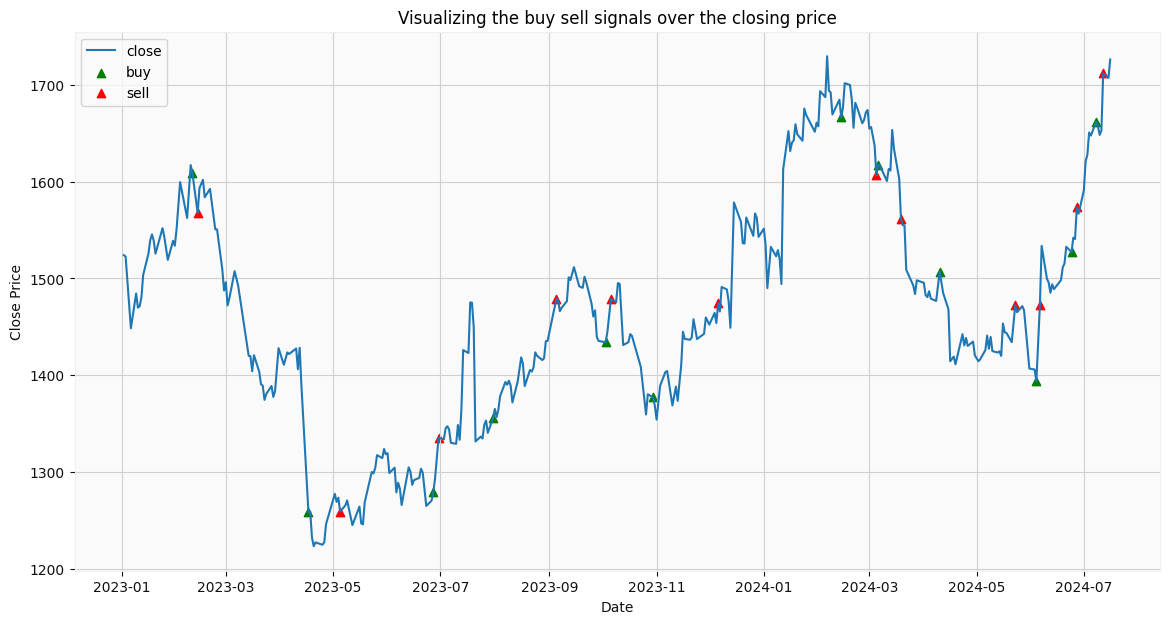

In [32]:
buy_signals = [trade['buy_price'] for trade in trades]
sell_signals = [trade['sell_price'] for trade in trades]
sell_time = [trade['sell_date'] for trade in trades]
buy_time = [trade['buy_date'] for trade in trades]
plt.figure(figsize=(14, 7))
plt.plot(signals_df.index,signals_df['close'],label='close')
plt.scatter(buy_time,buy_signals,marker='^',color='green',label='buy',alpha=1)
plt.scatter(sell_time,sell_signals,marker='^',color='red',label='sell',alpha=1)
plt.title('Visualizing the buy sell signals over the closing price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [33]:
trades_df = pd.DataFrame(trades)
trades_df['buy_date'] = pd.to_datetime(trades_df['buy_date'])
trades_df['sell_date'] = pd.to_datetime(trades_df['sell_date'])
print(len(trades_df[trades_df['profit_loss'] > 0]))
trades_df[trades_df['profit_loss'] > 0]

8


,buy_date,buy_price,target_profit,stop_loss,total_buy_price,quantity,sell_date,sell_price,total_selling_price,profit_loss,total_profit_loss,available_capital
1,2023-04-17 00:00:00+05:30,1258.30,1296.0490,1233.134,8808.10,7.0,2023-05-05 00:00:00+05:30,1259.10,8813.70,0.80,5.60,9759.00
2,2023-06-27 00:00:00+05:30,1279.15,1317.5245,1253.567,8954.05,7.0,2023-06-30 00:00:00+05:30,1335.50,9348.50,56.35,394.45,10153.45
3,2023-07-31 00:00:00+05:30,1355.70,1396.3710,1328.586,9489.90,7.0,2023-09-05 00:00:00+05:30,1478.90,10352.30,123.20,862.40,11015.85
4,2023-10-03 00:00:00+05:30,1434.00,1477.0200,1405.320,10038.00,7.0,2023-10-06 00:00:00+05:30,1478.70,10350.90,44.70,312.90,11328.75
5,2023-10-30 00:00:00+05:30,1377.05,1418.3615,1349.509,11016.40,8.0,2023-12-06 00:00:00+05:30,1474.30,11794.40,97.25,778.00,12106.75
9,2024-06-04 00:00:00+05:30,1393.65,1435.4595,1365.777,9755.55,7.0,2024-06-06 00:00:00+05:30,1472.25,10305.75,78.60,550.20,11605.55
10,2024-06-24 00:00:00+05:30,1527.15,1572.9645,1496.607,10690.05,7.0,2024-06-27 00:00:00+05:30,1573.35,11013.45,46.20,323.40,11928.95
11,2024-07-08 00:00:00+05:30,1661.65,1711.4995,1628.417,11631.55,7.0,2024-07-12 00:00:00+05:30,1711.75,11982.25,50.10,350.70,12279.65


In [34]:
trades_df[trades_df['profit_loss'] < 0]

,buy_date,buy_price,target_profit,stop_loss,total_buy_price,quantity,sell_date,sell_price,total_selling_price,profit_loss,total_profit_loss,available_capital
0,2023-02-10 00:00:00+05:30,1608.55,1656.8065,1576.379,9651.30,6.0,2023-02-13 00:00:00+05:30,1567.45,9404.70,-41.1,-246.6,9753.40
6,2024-02-14 00:00:00+05:30,1666.20,1716.1860,1632.876,11663.40,7.0,2024-03-05 00:00:00+05:30,1606.50,11245.50,-59.7,-417.9,11688.85
7,2024-03-06 00:00:00+05:30,1617.55,1666.0765,1585.199,11322.85,7.0,2024-03-19 00:00:00+05:30,1561.45,10930.15,-56.1,-392.7,11296.15
8,2024-04-10 00:00:00+05:30,1506.80,1552.0040,1476.664,10547.60,7.0,2024-05-23 00:00:00+05:30,1472.40,10306.80,-34.4,-240.8,11055.35


# Backtesting using backtesting.py

In [35]:

signals_df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close','volume':'Volume'}, inplace=True)

class MyStrategy(Strategy):
    def init(self):
        self.trail_sl = None

    def next(self):
        price = self.data.Close[-1]

        nearest_support = None
        nearest_resistance = None
        for level in filtered_levels_df.itertuples():
            if level.type == 'support' and abs(level.level - price) / price < 0.02:
                nearest_support = level.level
            if level.type == 'resistance' and abs(level.level - price) / price < 0.02:
                nearest_resistance = level.level

        if not self.position and nearest_support is not None:
            if (self.data.bullish_bearish_engulfing[-1] == 2 or self.data.hammer[-1] == 1):
                stop_loss = price * (1 - loss_percentage / 100)
                take_profit = price * (1 + profit_percentage / 100)
                self.buy(sl=stop_loss, tp=take_profit)
                self.trail_sl = stop_loss

        elif self.position and price > price * (1 + profit_percentage / 100):
            self.position.sl = max(self.trail_sl, self.position.price)

        elif self.position and nearest_resistance is not None:
            if (self.data.bullish_bearish_engulfing[-1] == 1 or self.data.shooting_star[-1] == 1):
                self.position.close()

profit_percentage = 3
loss_percentage = 2
signals_df = signals_df[['Open', 'High', 'Low', 'Close', 'Volume', 'bullish_bearish_engulfing', 'hammer', 'shooting_star']]

bt = Backtest(signals_df, MyStrategy, cash=10000, commission=.002)
stats = bt.run()
print(stats)

bt.plot()


Start                     2023-01-02 00:00...
End                       2024-07-16 00:00...
Duration                    561 days 00:00:00
Exposure Time [%]                   24.935065
Equity Final [$]                   11028.7452
Equity Peak [$]                    11028.7452
Return [%]                          10.287452
Buy & Hold Return [%]               13.257874
Return (Ann.) [%]                     6.69093
Volatility (Ann.) [%]                8.879382
Sharpe Ratio                         0.753536
Sortino Ratio                        1.375163
Calmar Ratio                         0.740938
Max. Drawdown [%]                   -9.030347
Avg. Drawdown [%]                   -2.368474
Max. Drawdown Duration      233 days 00:00:00
Avg. Drawdown Duration       49 days 00:00:00
# Trades                                   16
Win Rate [%]                             62.5
Best Trade [%]                       3.443639
Worst Trade [%]                     -3.092826
Avg. Trade [%]                    

c:\Users\rsurs\miniconda3\envs\algo\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\rsurs\miniconda3\envs\algo\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\rsurs\miniconda3\envs\algo\lib\site-packages\backtesting\_plotting.py:455: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df2 = (df.assign(_width=1).set_index('datetime')
c:\Users\rsurs\miniconda3\envs\algo\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
c:\Users\rsurs\miniconda3\envs\algo\lib\site-packages\backtestin

GridPlot(id='p1305', ...)

# Defining the functions to place orders on live data 

In [36]:
def placeOrder(symbol, quantity, stop_loss_price, target_profit_price):    
    t_type_buy = kite.TRANSACTION_TYPE_BUY
    t_type_sell = kite.TRANSACTION_TYPE_SELL

    market_order = kite.place_order(
        tradingsymbol=symbol,
        exchange=kite.EXCHANGE_NSE,
        transaction_type=t_type_buy,
        quantity=quantity,
        order_type=kite.ORDER_TYPE_MARKET,
        product=kite.PRODUCT_CNC,
        variety=kite.VARIETY_REGULAR
    )

    max_retries = 10
    for attempt in range(max_retries):
        try:
            order_list = kite.orders()
            break
        except:
            print("Can't get orders... retrying")
            if attempt == max_retries - 1:
                raise Exception("Failed to retrieve orders after multiple attempts")

    for order in order_list:
        if order["order_id"] == market_order and order["status"] == "COMPLETE":
            # Place the stop loss order
            kite.place_order(
                tradingsymbol=symbol,
                exchange=kite.EXCHANGE_NSE,
                transaction_type=t_type_sell,
                quantity=quantity,
                order_type=kite.ORDER_TYPE_SL,
                price=stop_loss_price,
                trigger_price=stop_loss_price,
                product=kite.PRODUCT_CNC,
                variety=kite.VARIETY_REGULAR
            )
            # Place the target profit order
            kite.place_order(
                tradingsymbol=symbol,
                exchange=kite.EXCHANGE_NSE,
                transaction_type=t_type_sell,
                quantity=quantity,
                order_type=kite.ORDER_TYPE_LIMIT,
                price=target_profit_price,
                product=kite.PRODUCT_CNC,
                variety=kite.VARIETY_REGULAR
            )
            print(f"Buy order complete. Stop loss and target profit orders placed.")
        else:
            kite.cancel_order(order_id=market_order, variety=kite.VARIETY_REGULAR)
            print(f"Market buy order failed, order canceled.")


# Place orders on live market data from zerodha 

In [ ]:
capital = 2000
trades = []
total_profit_loss = 0
pos = False
buy_price, stop_loss, take_profit, trailing_stop_loss = 0, 0, 0, 0

def main(capital, ohlc, ticker):
    global buy_price, stop_loss, take_profit, trailing_stop_loss, pos, total_profit_loss
    a, b = 0, 0
    
    while a < 10:
        try:
            pos_df = pd.DataFrame(kite.positions()["day"])
            break
        except:
            print("can't extract position data..retrying")
            a += 1

    while b < 10:
        try:
            ord_df = pd.DataFrame(kite.orders())
            break
        except:
            print("can't extract order data..retrying")
            b += 1

    hammer_signal = hammer(ohlc)
    shooting_star_signal = shooting_star(hammer_signal)
    signals = engulfing_signal(shooting_star_signal)
    supports = find_support(ohlc)
    resistances = find_resistance(ohlc)
    levels = find_sp_resistance_levels(supports, resistances)
    filter_levels = masking_filter(levels)
    nearest_support = None
    nearest_resistance = None
    current_price = ohlc["close"].iloc[-1]
    for level in filter_levels.itertuples():
        if level.type == 'support' and abs(level.level - current_price) / current_price < 0.02:
            nearest_support = level.level
        if level.type == 'resistance' and abs(level.level - current_price) / current_price < 0.02:
            nearest_resistance = level.level


    if not pos and nearest_support is not None:
        if (signals[-1] == 2 or hammer_signal[-1] == 1):
            buy_price = current_price
            quantity = capital // current_price
            buy_date = ohlc.index[-1]
            total_buy_price = buy_price * quantity
            stop_loss = buy_price - (buy_price * (loss_percentage / 100))
            take_profit = buy_price + (buy_price * (profit_percentage / 100))
            trailing_stop_loss = stop_loss
            placeOrder(ticker, quantity, stop_loss, take_profit)
            pos = True
            capital -= buy_price * quantity
            print(f"Buy Signal: {buy_price} at {ohlc.index[-1]}")

    elif pos and nearest_resistance is not None and ticker in pos_df["tradingsymbol"].tolist():
        if pos_df[pos_df["tradingsymbol"] == ticker]["quantity"].values[0] > 0:
            order_id = ord_df.loc[(ord_df['tradingsymbol'] == ticker) & (ord_df['status'].isin(["TRIGGER PENDING", "OPEN"]))]["order_id"].values[0]

            if current_price > buy_price * (1 + profit_percentage / 100):
                trailing_stop_loss = max(trailing_stop_loss, current_price - (current_price * (loss_percentage / 100)))

            if (signals[-1] == 1 or shooting_star_signal[-1] == 1 or current_price >= take_profit or current_price <= trailing_stop_loss):
                sell_price = current_price
                total_sell_price = sell_price * quantity
                ModifyOrder(order_id,trailing_stop_loss)
                profit_loss = (sell_price - buy_price) 
                total_profit_loss = total_sell_price - total_buy_price
                capital += sell_price * quantity
                sell_date = ohlc.index[-1]
                trades.append({
                    'ticker': ticker,
                    'buy_date': buy_date,
                    'buy_price': buy_price,
                    'sell_date': sell_date,
                    'sell_price': sell_price,
                    'profit_loss': profit_loss,
                    'total_profit_loss': total_profit_loss,
                    'available_capital': capital
                })
                pos = False
                print(f"Sell Signal: {sell_price} at {ohlc.index[-1]}")

    return trades, total_profit_loss

def ModifyOrder(order_id, price):
    # Modify order given order id
    kite.modify_order(order_id=order_id,
                      price=price,
                      trigger_price=price,
                      order_type=kite.ORDER_TYPE_SL,
                      variety=kite.VARIETY_REGULAR)

tickers = ['INFY']
kws = KiteTicker(api_key, access_token)
tokens = tokenLookup(instrument_df, tickers)

def on_ticks(ws, ticks):
    for tick in ticks:
        token = tick['instrument_token']
        ticker = instrument_df[instrument_df['instrument_token'] == token].tradingsymbol.values[0]
        print(f"Received tick for {ticker}: {tick}")
        
        ohlc = fetchOHLCExtended(ticker, "31-12-2022", 'day')        
        trades, total_profit_loss = main(capital, ohlc, ticker)
        
        print("\nTrade Summary:")
        for trade in trades:
            print(f"Bought {trade['ticker']} at {trade['buy_price']} on {trade['buy_date']} and sold at {trade['sell_price']} on {trade['sell_date']}, Profit/Loss: {trade['profit_loss']:.2f}")
        print(f"\nTotal Profit/Loss: {total_profit_loss:.2f}")

def on_connect(ws, response):
    ws.subscribe(tokens)
    ws.set_mode(ws.MODE_LTP, tokens)

def on_close(ws, code, reason):
    ws.stop()

while True:
    now = dt.datetime.now()
    if now.hour >= 9:
        kws.on_ticks = on_ticks
        kws.on_connect = on_connect
        kws.connect()
    if now.hour >= 14 and now.minute >= 30:
        sys.exit()


# Implementing an LSTM 

In [ ]:
data = fetchOHLCExtended('INFY','01-01-2014','day')
data.head()

,open,high,low,close,volume
date,,,,,
2014-01-01 00:00:00+05:30,436.50,437.38,432.76,433.50,1478688
2014-01-02 00:00:00+05:30,432.91,438.50,432.91,435.07,4404744
2014-01-03 00:00:00+05:30,434.38,446.88,431.78,445.65,10046344
2014-01-06 00:00:00+05:30,446.89,447.56,433.58,439.74,11098328
2014-01-07 00:00:00+05:30,439.88,440.74,430.84,432.15,7713688


Features considered logarthimic returns, volatility and trading volumes 

In [ ]:
data['Log_Ret_1d']=np.log(data['close'] / data['close'].shift(1))

data['Log_Ret_1w']=pd.Series(data['Log_Ret_1d']).rolling(window=5).sum()
data['Log_Ret_2w']=pd.Series(data['Log_Ret_1d']).rolling(window=10).sum()
data['Log_Ret_3w']=pd.Series(data['Log_Ret_1d']).rolling(window=15).sum()
data['Log_Ret_4w']=pd.Series(data['Log_Ret_1d']).rolling(window=20).sum()
data['Log_Ret_8w']=pd.Series(data['Log_Ret_1d']).rolling(window=40).sum()
data['Log_Ret_12w']=pd.Series(data['Log_Ret_1d']).rolling(window=60).sum()
data['Log_Ret_16w']=pd.Series(data['Log_Ret_1d']).rolling(window=80).sum()
data['Log_Ret_20w']=pd.Series(data['Log_Ret_1d']).rolling(window=100).sum()
data['Log_Ret_24w']=pd.Series(data['Log_Ret_1d']).rolling(window=120).sum()
data['Log_Ret_28w']=pd.Series(data['Log_Ret_1d']).rolling(window=140).sum()
data['Log_Ret_32w']=pd.Series(data['Log_Ret_1d']).rolling(window=160).sum()
data['Log_Ret_36w']=pd.Series(data['Log_Ret_1d']).rolling(window=180).sum()
data['Log_Ret_40w']=pd.Series(data['Log_Ret_1d']).rolling(window=200).sum()
data['Log_Ret_44w']=pd.Series(data['Log_Ret_1d']).rolling(window=220).sum()
data['Log_Ret_48w']=pd.Series(data['Log_Ret_1d']).rolling(window=240).sum()
data['Log_Ret_52w']=pd.Series(data['Log_Ret_1d']).rolling(window=260).sum()
data['Log_Ret_56w']=pd.Series(data['Log_Ret_1d']).rolling(window=280).sum()
data['Log_Ret_60w']=pd.Series(data['Log_Ret_1d']).rolling(window=300).sum()
data['Log_Ret_64w']=pd.Series(data['Log_Ret_1d']).rolling(window=320).sum()
data['Log_Ret_68w']=pd.Series(data['Log_Ret_1d']).rolling(window=340).sum()
data['Log_Ret_72w']=pd.Series(data['Log_Ret_1d']).rolling(window=360).sum()
data['Log_Ret_76w']=pd.Series(data['Log_Ret_1d']).rolling(window=380).sum()
data['Log_Ret_80w']=pd.Series(data['Log_Ret_1d']).rolling(window=400).sum()

data['Vol_1w']=pd.Series(data['Log_Ret_1d']).rolling(window=5).std()*np.sqrt(5)
data['Vol_2w']=pd.Series(data['Log_Ret_1d']).rolling(window=10).std()*np.sqrt(10)
data['Vol_3w']=pd.Series(data['Log_Ret_1d']).rolling(window=15).std()*np.sqrt(15)
data['Vol_4w']=pd.Series(data['Log_Ret_1d']).rolling(window=20).std()*np.sqrt(20)
data['Vol_8w']=pd.Series(data['Log_Ret_1d']).rolling(window=40).std()*np.sqrt(40)
data['Vol_12w']=pd.Series(data['Log_Ret_1d']).rolling(window=60).std()*np.sqrt(60)
data['Vol_16w']=pd.Series(data['Log_Ret_1d']).rolling(window=80).std()*np.sqrt(80)
data['Vol_20w']=pd.Series(data['Log_Ret_1d']).rolling(window=100).std()*np.sqrt(100)
data['Vol_24w']=pd.Series(data['Log_Ret_1d']).rolling(window=120).std()*np.sqrt(120)
data['Vol_28w']=pd.Series(data['Log_Ret_1d']).rolling(window=140).std()*np.sqrt(140)
data['Vol_32w']=pd.Series(data['Log_Ret_1d']).rolling(window=160).std()*np.sqrt(160)
data['Vol_36w']=pd.Series(data['Log_Ret_1d']).rolling(window=180).std()*np.sqrt(180)
data['Vol_40w']=pd.Series(data['Log_Ret_1d']).rolling(window=200).std()*np.sqrt(200)
data['Vol_44w']=pd.Series(data['Log_Ret_1d']).rolling(window=220).std()*np.sqrt(220)
data['Vol_48w']=pd.Series(data['Log_Ret_1d']).rolling(window=240).std()*np.sqrt(240)
data['Vol_52w']=pd.Series(data['Log_Ret_1d']).rolling(window=260).std()*np.sqrt(260)
data['Vol_56w']=pd.Series(data['Log_Ret_1d']).rolling(window=280).std()*np.sqrt(280)
data['Vol_60w']=pd.Series(data['Log_Ret_1d']).rolling(window=300).std()*np.sqrt(300)
data['Vol_64w']=pd.Series(data['Log_Ret_1d']).rolling(window=320).std()*np.sqrt(320)
data['Vol_68w']=pd.Series(data['Log_Ret_1d']).rolling(window=340).std()*np.sqrt(340)
data['Vol_72w']=pd.Series(data['Log_Ret_1d']).rolling(window=360).std()*np.sqrt(360)
data['Vol_76w']=pd.Series(data['Log_Ret_1d']).rolling(window=380).std()*np.sqrt(380)
data['Vol_80w']=pd.Series(data['Log_Ret_1d']).rolling(window=400).std()*np.sqrt(400)

# Compute Volumes using the pandas rolling mean function
data['Volume_1w']=pd.Series(data['volume']).rolling(window=5).mean()
data['Volume_2w']=pd.Series(data['volume']).rolling(window=10).mean()
data['Volume_3w']=pd.Series(data['volume']).rolling(window=15).mean()
data['Volume_4w']=pd.Series(data['volume']).rolling(window=20).mean()
data['Volume_8w']=pd.Series(data['volume']).rolling(window=40).mean()
data['Volume_12w']=pd.Series(data['volume']).rolling(window=60).mean()
data['Volume_16w']=pd.Series(data['volume']).rolling(window=80).mean()
data['Volume_20w']=pd.Series(data['volume']).rolling(window=100).mean()
data['Volume_24w']=pd.Series(data['volume']).rolling(window=120).mean()
data['Volume_28w']=pd.Series(data['volume']).rolling(window=140).mean()
data['Volume_32w']=pd.Series(data['volume']).rolling(window=160).mean()
data['Volume_36w']=pd.Series(data['volume']).rolling(window=180).mean()
data['Volume_40w']=pd.Series(data['volume']).rolling(window=200).mean()
data['Volume_44w']=pd.Series(data['volume']).rolling(window=220).mean()
data['Volume_48w']=pd.Series(data['volume']).rolling(window=240).mean()
data['Volume_52w']=pd.Series(data['volume']).rolling(window=260).mean()
data['Volume_56w']=pd.Series(data['volume']).rolling(window=280).mean()
data['Volume_60w']=pd.Series(data['volume']).rolling(window=300).mean()
data['Volume_64w']=pd.Series(data['volume']).rolling(window=320).mean()
data['Volume_68w']=pd.Series(data['volume']).rolling(window=340).mean()
data['Volume_72w']=pd.Series(data['volume']).rolling(window=360).mean()
data['Volume_76w']=pd.Series(data['volume']).rolling(window=380).mean()
data['Volume_80w']=pd.Series(data['volume']).rolling(window=400).mean()

data['Return_Label']=pd.Series(data['Log_Ret_1d']).shift(-21).rolling(window=21).sum()
data['Label']=np.where(data['Return_Label'] > 0, 1, 0)

data=data.dropna()
data=data.drop(['open', 'high', 'low', 'close', 'volume', "Return_Label"], axis=1)
data.head()


,Log_Ret_1d,Log_Ret_1w,Log_Ret_2w,Log_Ret_3w,Log_Ret_4w,Log_Ret_8w,Log_Ret_12w,Log_Ret_16w,Log_Ret_20w,Log_Ret_24w,...,Volume_48w,Volume_52w,Volume_56w,Volume_60w,Volume_64w,Volume_68w,Volume_72w,Volume_76w,Volume_80w,Label
date,,,,,,,,,,,,,,,,,,,,,
2015-08-14 00:00:00+05:30,-0.007576,0.047816,0.064883,0.055145,0.137260,0.143769,0.116144,0.079906,0.028722,0.006723,...,9.529886e+06,9.363445e+06,9.252974e+06,9.398833e+06,9.423261e+06,9.457705e+06,9.517216e+06,9.343941e+06,9486199.910,0
2015-08-17 00:00:00+05:30,-0.006197,0.050420,0.056924,0.069665,0.131662,0.109341,0.124556,0.135324,0.032425,0.008229,...,9.518492e+06,9.354867e+06,9.239462e+06,9.315739e+06,9.418083e+06,9.439853e+06,9.498516e+06,9.333214e+06,9482956.640,0
2015-08-18 00:00:00+05:30,0.019233,0.048551,0.096474,0.091210,0.045401,0.151754,0.148501,0.159844,0.048191,0.024289,...,9.512577e+06,9.353133e+06,9.228247e+06,9.308808e+06,9.417938e+06,9.426683e+06,9.490033e+06,9.330005e+06,9468216.895,0
2015-08-19 00:00:00+05:30,0.009590,0.026864,0.078930,0.079796,0.063566,0.166657,0.177610,0.181478,0.091118,0.014360,...,9.509537e+06,9.341343e+06,9.236130e+06,9.308957e+06,9.425137e+06,9.430286e+06,9.489843e+06,9.336546e+06,9457644.870,0
2015-08-20 00:00:00+05:30,-0.035500,-0.020449,0.042860,0.058586,0.032755,0.135831,0.117979,0.145856,0.029953,0.004859,...,9.529228e+06,9.341005e+06,9.244163e+06,9.318494e+06,9.402552e+06,9.441077e+06,9.499359e+06,9.346635e+06,9459283.435,0


In [ ]:
data.tail()

,Log_Ret_1d,Log_Ret_1w,Log_Ret_2w,Log_Ret_3w,Log_Ret_4w,Log_Ret_8w,Log_Ret_12w,Log_Ret_16w,Log_Ret_20w,Log_Ret_24w,...,Volume_48w,Volume_52w,Volume_56w,Volume_60w,Volume_64w,Volume_68w,Volume_72w,Volume_76w,Volume_80w,Label
date,,,,,,,,,,,,,,,,,,,,,
2024-06-04 00:00:00+05:30,-0.008751,-0.051327,-0.042942,-0.018695,-0.023858,-0.059508,-0.142132,-0.195019,-0.092884,-0.065843,...,6.675691e+06,6.644456e+06,6.674180e+06,6.906163e+06,6.865113e+06,6.771621e+06,6.755662e+06,6.724060e+06,6.591551e+06,1
2024-06-05 00:00:00+05:30,0.025818,-0.014474,-0.029149,-0.016127,-0.006586,-0.032065,-0.123168,-0.168226,-0.060900,-0.031625,...,6.697324e+06,6.661415e+06,6.682841e+06,6.911582e+06,6.882542e+06,6.783482e+06,6.767810e+06,6.740117e+06,6.603279e+06,1
2024-06-06 00:00:00+05:30,0.029047,0.030902,0.004868,0.019167,0.032690,-0.015234,-0.093441,-0.125642,-0.014799,0.015918,...,6.722259e+06,6.693441e+06,6.707772e+06,6.928588e+06,6.907211e+06,6.808489e+06,6.789007e+06,6.742203e+06,6.623575e+06,1
2024-06-07 00:00:00+05:30,0.040826,0.086229,0.041438,0.060443,0.074534,0.017630,-0.042761,-0.091235,-0.050323,0.021187,...,6.792408e+06,6.764802e+06,6.765110e+06,6.994938e+06,6.973724e+06,6.861034e+06,6.843037e+06,6.791328e+06,6.676416e+06,1
2024-06-10 00:00:00+05:30,-0.022319,0.064621,0.022045,0.044726,0.051337,0.010052,-0.072766,-0.116200,-0.096749,-0.051113,...,6.806606e+06,6.773999e+06,6.753297e+06,6.995529e+06,6.979632e+06,6.860581e+06,6.847898e+06,6.797978e+06,6.685507e+06,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2204 entries, 2015-08-14 00:00:00+05:30 to 2024-06-10 00:00:00+05:30
Data columns (total 71 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Log_Ret_1d   2204 non-null   float64
 1   Log_Ret_1w   2204 non-null   float64
 2   Log_Ret_2w   2204 non-null   float64
 3   Log_Ret_3w   2204 non-null   float64
 4   Log_Ret_4w   2204 non-null   float64
 5   Log_Ret_8w   2204 non-null   float64
 6   Log_Ret_12w  2204 non-null   float64
 7   Log_Ret_16w  2204 non-null   float64
 8   Log_Ret_20w  2204 non-null   float64
 9   Log_Ret_24w  2204 non-null   float64
 10  Log_Ret_28w  2204 non-null   float64
 11  Log_Ret_32w  2204 non-null   float64
 12  Log_Ret_36w  2204 non-null   float64
 13  Log_Ret_40w  2204 non-null   float64
 14  Log_Ret_44w  2204 non-null   float64
 15  Log_Ret_48w  2204 non-null   float64
 16  Log_Ret_52w  2204 non-null   float64
 17  Log_Ret_56w  2204 non-null   float64
 18  

In [ ]:
data.describe()

,Log_Ret_1d,Log_Ret_1w,Log_Ret_2w,Log_Ret_3w,Log_Ret_4w,Log_Ret_8w,Log_Ret_12w,Log_Ret_16w,Log_Ret_20w,Log_Ret_24w,...,Volume_48w,Volume_52w,Volume_56w,Volume_60w,Volume_64w,Volume_68w,Volume_72w,Volume_76w,Volume_80w,Label
count,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,...,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2.204000e+03,2204.000000
mean,0.000432,0.002185,0.004403,0.006681,0.008942,0.018633,0.028723,0.039669,0.049767,0.058940,...,8.162050e+06,8.178610e+06,8.193560e+06,8.206963e+06,8.220533e+06,8.234416e+06,8.249071e+06,8.263078e+06,8.277341e+06,0.607532
std,0.016825,0.036818,0.050425,0.060871,0.070067,0.096812,0.115906,0.134272,0.145315,0.160476,...,1.549872e+06,1.514546e+06,1.479846e+06,1.447302e+06,1.417270e+06,1.386910e+06,1.356027e+06,1.323824e+06,1.291320e+06,0.488411
min,-0.176595,-0.249920,-0.339074,-0.401652,-0.414698,-0.396657,-0.330853,-0.279696,-0.303362,-0.425493,...,6.075458e+06,6.241686e+06,6.184027e+06,6.191217e+06,6.224974e+06,6.198570e+06,6.165381e+06,6.149875e+06,6.182463e+06,0.000000
25%,-0.008123,-0.015561,-0.022116,-0.025944,-0.030073,-0.036251,-0.049018,-0.055546,-0.046652,-0.034949,...,6.592532e+06,6.620983e+06,6.655034e+06,6.730605e+06,6.849405e+06,6.967416e+06,7.050665e+06,7.056415e+06,7.079497e+06,0.000000
50%,0.000202,0.003441,0.008569,0.011158,0.017942,0.023915,0.032115,0.038340,0.043035,0.049314,...,8.022907e+06,8.091806e+06,8.186567e+06,8.191170e+06,8.379938e+06,8.509818e+06,8.597683e+06,8.596120e+06,8.587725e+06,1.000000
75%,0.009531,0.023290,0.034760,0.042498,0.053071,0.084904,0.108481,0.124662,0.140572,0.167600,...,9.497643e+06,9.483766e+06,9.419793e+06,9.322536e+06,9.332206e+06,9.385678e+06,9.375005e+06,9.410087e+06,9.367528e+06,1.000000
max,0.113627,0.178965,0.206446,0.262749,0.283445,0.338514,0.388739,0.576260,0.598169,0.619762,...,1.132046e+07,1.143626e+07,1.131456e+07,1.122800e+07,1.118505e+07,1.109935e+07,1.086995e+07,1.072885e+07,1.066017e+07,1.000000


# Plotting the log returns 

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>], dtype=object)

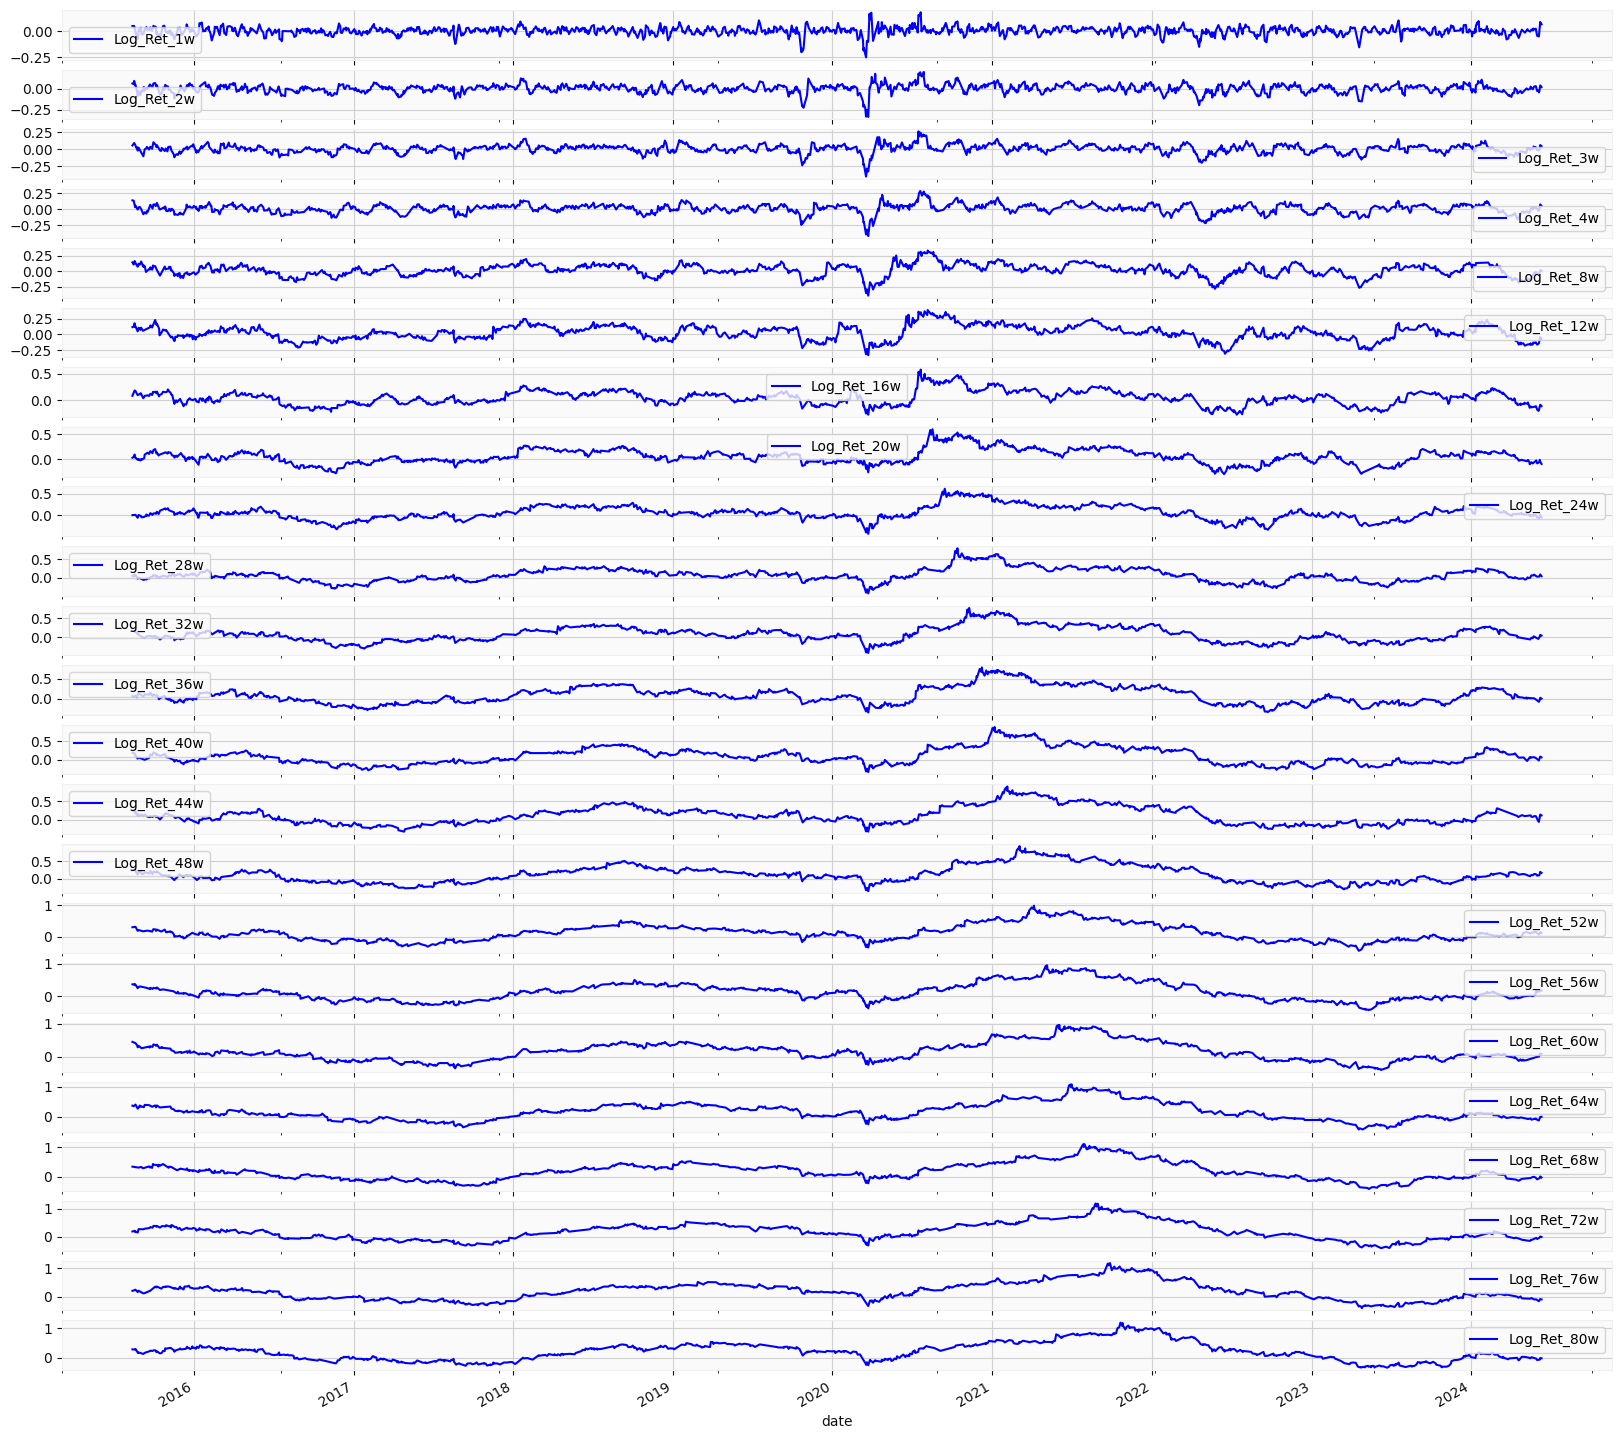

In [ ]:
data.iloc[:,1:24].plot(subplots=True,color='blue',figsize=(20,20))

# Plotting the Volatilities 

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>], dtype=object)

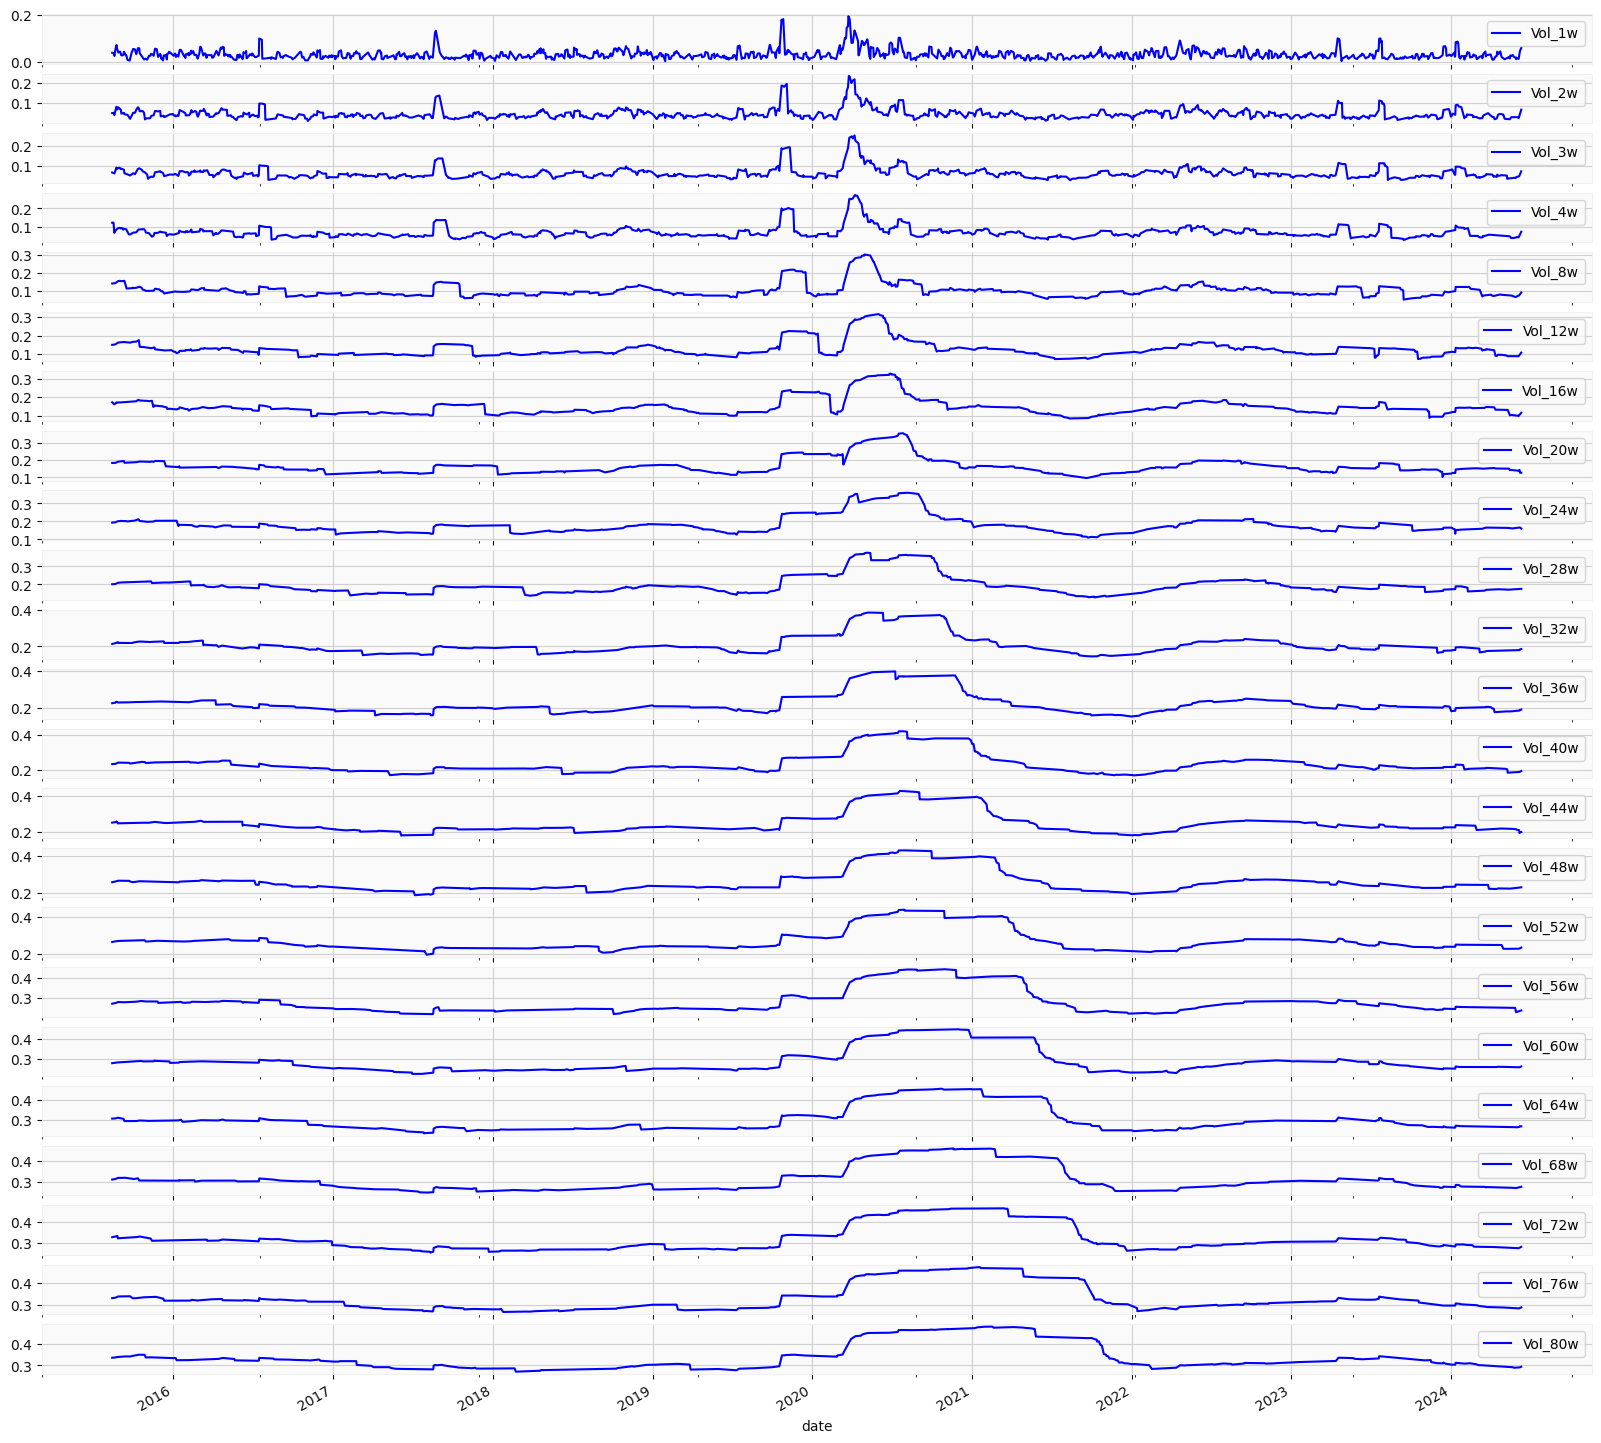

In [ ]:
data.iloc[:,24:47].plot(subplots=True,color='blue',figsize=(20,20))

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>], dtype=object)

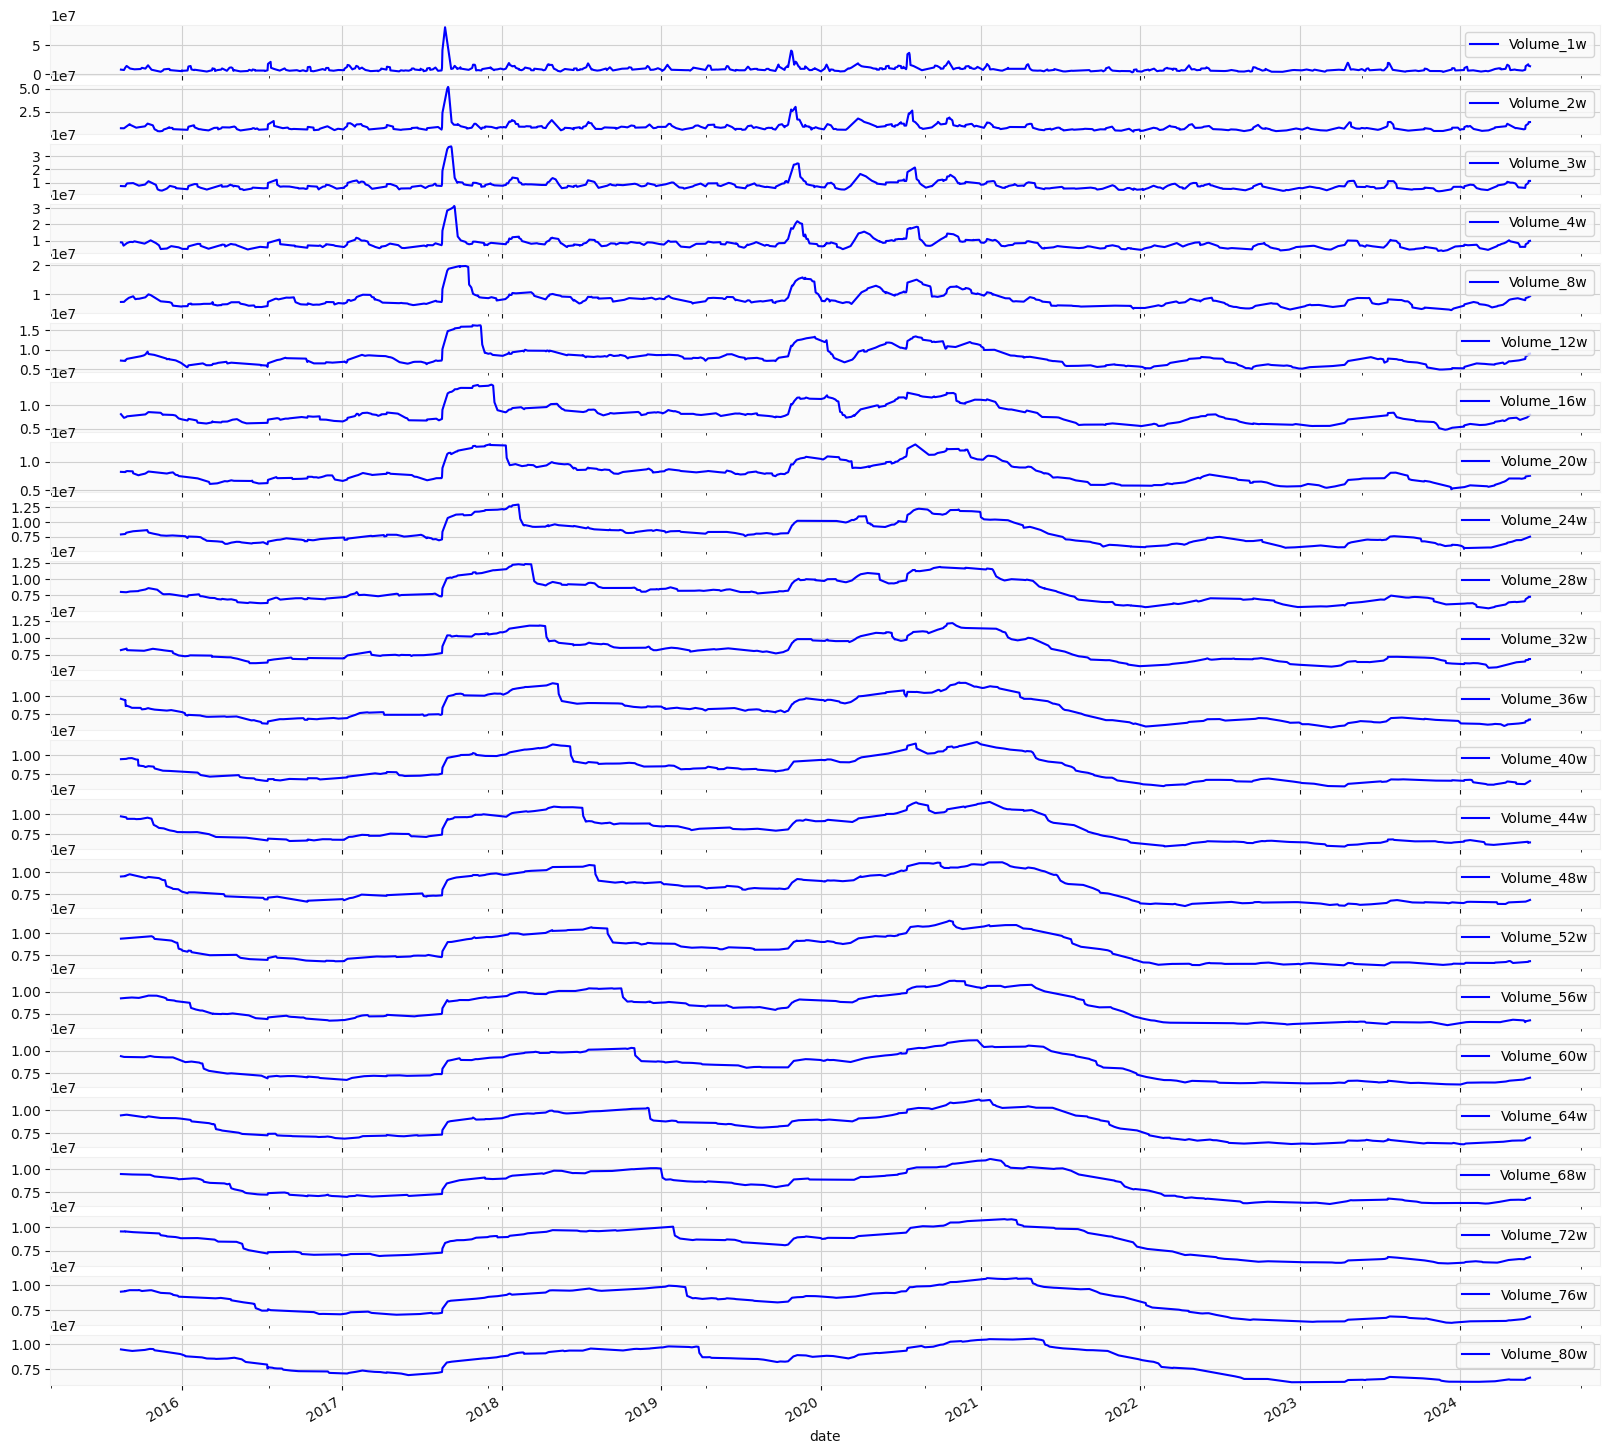

In [ ]:
data.iloc[:,47:70].plot(subplots=True,color='blue',figsize=(20,20))

# Plotting a correlation matrix 

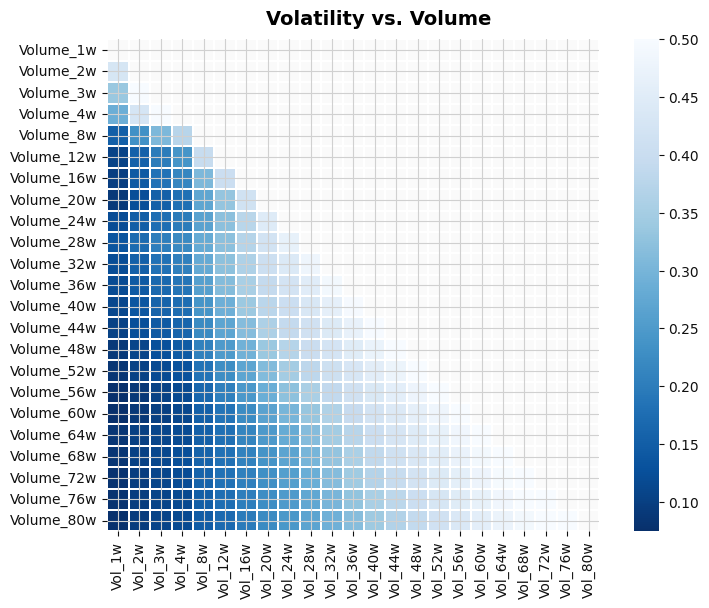

In [ ]:
#Volumes 

focus_cols=data.iloc[:,24:47].columns 

corr=data.iloc[:,24:70].corr().filter(focus_cols).drop(focus_cols)

mask=np.zeros_like(corr); mask[np.triu_indices_from(mask)]=True 

heat_fig, (ax)=plt.subplots(1, 1, figsize=(9,6))

heat=sns.heatmap(corr, 
                   ax=ax, 
                   mask=mask, 
                   vmax=.5, 
                   square=True, 
                   linewidths=.2, 
                   cmap="Blues_r")

heat_fig.subplots_adjust(top=.93)

heat_fig.suptitle('Volatility vs. Volume', fontsize=14, fontweight='bold')

plt.savefig('heat2.eps', dpi=200, format='eps');


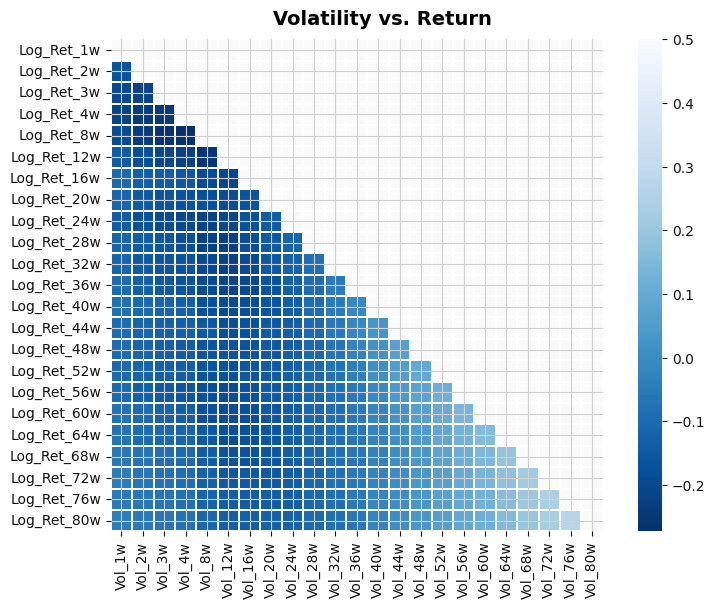

In [ ]:
# Returns
focus_cols=data.iloc[:,24:47].columns 

corr=data.iloc[:,1:47].corr().filter(focus_cols).drop(focus_cols)

mask=np.zeros_like(corr); mask[np.triu_indices_from(mask)]=True 

heat_fig, (ax)=plt.subplots(1, 1, figsize=(9,6))

heat=sns.heatmap(corr, 
                   ax=ax, 
                   mask=mask, 
                   vmax=.5, 
                   square=True, 
                   linewidths=.2, 
                   cmap="Blues_r")

heat_fig.subplots_adjust(top=.93)

heat_fig.suptitle('Volatility vs. Return', fontsize=14, fontweight='bold')

plt.savefig('heat2.eps', dpi=200, format='eps');


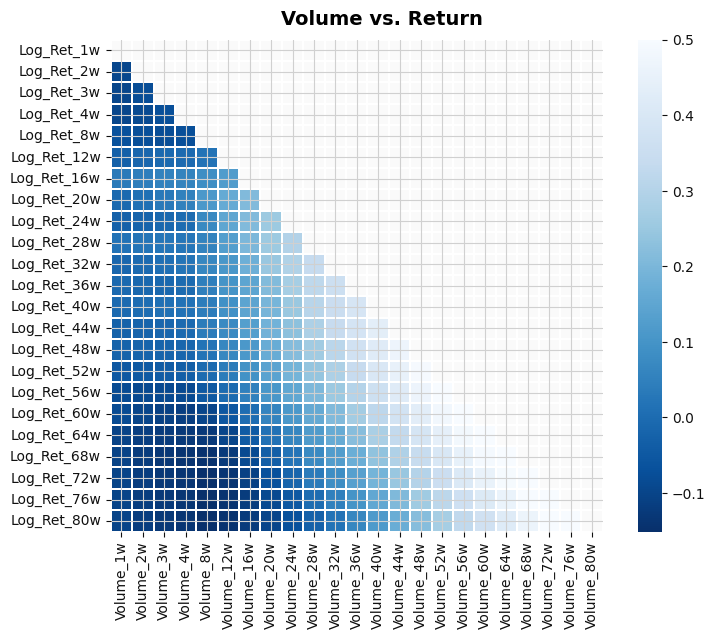

In [ ]:
focus_cols=data.iloc[:,47:70].columns 

corr=data.iloc[:, np.r_[1:24, 47:70]].corr().filter(focus_cols).drop(focus_cols)

mask=np.zeros_like(corr); mask[np.triu_indices_from(mask)]=True # we use mask to plot only part of the matrix

heat_fig, (ax)=plt.subplots(1, 1, figsize=(9,6))

heat=sns.heatmap(corr, 
                   ax=ax, 
                   mask=mask, 
                   vmax=.5, 
                   square=True, 
                   linewidths=.2, 
                   cmap="Blues_r")

heat_fig.subplots_adjust(top=.93)

heat_fig.suptitle('Volume vs. Return', fontsize=14, fontweight='bold')

plt.savefig('heat3.eps', dpi=200, format='eps');


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
dev_size=0.1 
n_splits=int((1//dev_size)-1)  
tscv=TimeSeriesSplit(n_splits=n_splits) 
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None)

In [ ]:
data.head()

,Log_Ret_1d,Log_Ret_1w,Log_Ret_2w,Log_Ret_3w,Log_Ret_4w,Log_Ret_8w,Log_Ret_12w,Log_Ret_16w,Log_Ret_20w,Log_Ret_24w,...,Volume_48w,Volume_52w,Volume_56w,Volume_60w,Volume_64w,Volume_68w,Volume_72w,Volume_76w,Volume_80w,Label
date,,,,,,,,,,,,,,,,,,,,,
2015-08-14 00:00:00+05:30,-0.007576,0.047816,0.064883,0.055145,0.137260,0.143769,0.116144,0.079906,0.028722,0.006723,...,9.529886e+06,9.363445e+06,9.252974e+06,9.398833e+06,9.423261e+06,9.457705e+06,9.517216e+06,9.343941e+06,9486199.910,0
2015-08-17 00:00:00+05:30,-0.006197,0.050420,0.056924,0.069665,0.131662,0.109341,0.124556,0.135324,0.032425,0.008229,...,9.518492e+06,9.354867e+06,9.239462e+06,9.315739e+06,9.418083e+06,9.439853e+06,9.498516e+06,9.333214e+06,9482956.640,0
2015-08-18 00:00:00+05:30,0.019233,0.048551,0.096474,0.091210,0.045401,0.151754,0.148501,0.159844,0.048191,0.024289,...,9.512577e+06,9.353133e+06,9.228247e+06,9.308808e+06,9.417938e+06,9.426683e+06,9.490033e+06,9.330005e+06,9468216.895,0
2015-08-19 00:00:00+05:30,0.009590,0.026864,0.078930,0.079796,0.063566,0.166657,0.177610,0.181478,0.091118,0.014360,...,9.509537e+06,9.341343e+06,9.236130e+06,9.308957e+06,9.425137e+06,9.430286e+06,9.489843e+06,9.336546e+06,9457644.870,0
2015-08-20 00:00:00+05:30,-0.035500,-0.020449,0.042860,0.058586,0.032755,0.135831,0.117979,0.145856,0.029953,0.004859,...,9.529228e+06,9.341005e+06,9.244163e+06,9.318494e+06,9.402552e+06,9.441077e+06,9.499359e+06,9.346635e+06,9459283.435,0


In [ ]:
data['Label'].head()

date
2015-08-14 00:00:00+05:30    0
2015-08-17 00:00:00+05:30    0
2015-08-18 00:00:00+05:30    0
2015-08-19 00:00:00+05:30    0
2015-08-20 00:00:00+05:30    0
Name: Label, dtype: int32

In [ ]:
df_copy = data.copy()

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
data_scaled = sc.fit_transform(df_copy)
print(data_scaled)

[[0.58237716 0.69421054 0.7404996  ... 0.69754983 0.73781843 0.        ]
 [0.58712894 0.70028183 0.72590882 ... 0.69520721 0.73709411 0.        ]
 [0.67475243 0.69592506 0.79840879 ... 0.69450636 0.73380231 0.        ]
 ...
 [0.70856889 0.65477361 0.63048558 ... 0.12935801 0.09851278 1.        ]
 [0.74915371 0.78377567 0.69752115 ... 0.14008631 0.11031368 1.        ]
 [0.53157683 0.73339278 0.66197207 ... 0.14153875 0.11234406 1.        ]]


In [ ]:
backcandles = 30 

X = []
for j in range(data_scaled.shape[1]-1):
    X.append([])
    for i in range(backcandles, data_scaled.shape[0]):
        X[j].append(data_scaled[i-backcandles:i, j])

X = np.moveaxis(X, [0], [2])
X = np.array(X)

y = data_scaled[backcandles:, -1].reshape(-1, 1)
print(X.shape)  
print(y.shape)  
y = y.reshape(len(y), 1)
print(X.shape)
print(y.shape)

(2174, 30, 70)
(2174, 1)
(2174, 30, 70)
(2174, 1)


In [ ]:
split_limit = int(len(X) * 0.9)
X_train,X_test,y_train,y_test = X[:split_limit],X[split_limit:],y[:split_limit],y[split_limit:]
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1956, 30, 70) (218, 30, 70) (1956, 1) (218, 1)


# Defining the Pytorch dataset class

In [ ]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


In [ ]:
train_dataset = StockDataset(X_train,y_train)
test_dataset = StockDataset(X_test,y_test)
batch_size = 32 
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 30, 70]) torch.Size([32, 1])


# Defining the baseline logistic regression model

In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  
        return torch.sigmoid(self.linear(x))

class LogisticRegressionModelL1(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModelL1, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return torch.sigmoid(self.linear(x))

# Model architecture 

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout_rate):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return torch.sigmoid(out)



In [ ]:

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, patience=2):
    best_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        model.train()
        correct_train = 0
        total_train = 0
        train_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_accuracy = correct_train / total_train
        train_loss /= len(train_loader)

        val_accuracy, val_loss = evaluate_model(model, val_loader)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Accuracy: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}, Test Accuracy: {val_accuracy:.4f}, Test Loss: {val_loss:.4f}')

        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping!")
                break
    
    return model

def evaluate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    criterion = nn.BCELoss()

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    return correct / total, val_loss

input_dim_lstm = X_train.shape[2]
hidden_dim = 200  
num_layers = 2
output_dim = 1
dropout_rate = 0.5

alpha_g_6_b = [0.001, 0.005]
l1_ratio_g_6_b = [0.1, 0.3, 0.5]
iterations_6_b = [10]
batch_size = [32, 64]

best_score = 0
best_params = None

tscv = TimeSeriesSplit(n_splits=5)

for alpha in alpha_g_6_b:
    for l1_ratio in l1_ratio_g_6_b:
        for num_iter in iterations_6_b:
            for batch in batch_size:
                scores = []
                for train_index, val_index in tscv.split(X_train):
                    X_tr, X_val = X_train[train_index], X_train[val_index]
                    y_tr, y_val = y_train[train_index], y_train[val_index]

                    train_dataset = StockDataset(X_tr, y_tr)
                    val_dataset = StockDataset(X_val, y_val)

                    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
                    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

                    model = LSTMModel(input_dim_lstm, hidden_dim, num_layers, output_dim, dropout_rate).to(device)
                    criterion = nn.BCELoss()
                    optimizer = torch.optim.Adam(model.parameters(), lr=alpha, weight_decay=l1_ratio)

                    model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=num_iter)
                    score, _ = evaluate_model(model, val_loader)
                    scores.append(score)
                
                avg_score = np.mean(scores)
                if avg_score > best_score:
                    best_score = avg_score
                    best_params = {
                        'alpha': alpha,
                        'l1_ratio': l1_ratio,
                        'num_iter': num_iter,
                        'batch_size': batch
                    }

print(f'Best Score: {best_score}')
print('Best Hyperparameters:')
print(best_params)

alpha = best_params['alpha']
l1_ratio = best_params['l1_ratio']
num_iter = best_params['num_iter']
batch = best_params['batch_size']

train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False)

final_model = LSTMModel(input_dim_lstm, hidden_dim, num_layers, output_dim, dropout_rate).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=alpha, weight_decay=l1_ratio)

final_model = train_model(final_model, criterion, optimizer, train_loader, val_loader, num_epochs=num_iter)
final_score, _ = evaluate_model(final_model, val_loader)

print(f'Final LSTM Model Accuracy: {final_score:.4f}')


Epoch 1/10, Train Accuracy: 0.5706, Train Loss: 0.6893, Test Accuracy: 0.3313, Test Loss: 0.7127
Epoch 2/10, Train Accuracy: 0.5706, Train Loss: 0.6855, Test Accuracy: 0.3313, Test Loss: 0.7134
Epoch 3/10, Train Accuracy: 0.5706, Train Loss: 0.6850, Test Accuracy: 0.3313, Test Loss: 0.7162
Early stopping!
Epoch 1/10, Train Accuracy: 0.4724, Train Loss: 0.6944, Test Accuracy: 0.6380, Test Loss: 0.6928
Epoch 2/10, Train Accuracy: 0.5245, Train Loss: 0.6931, Test Accuracy: 0.6656, Test Loss: 0.6929
Epoch 3/10, Train Accuracy: 0.5291, Train Loss: 0.6929, Test Accuracy: 0.6656, Test Loss: 0.6928
Epoch 4/10, Train Accuracy: 0.5245, Train Loss: 0.6930, Test Accuracy: 0.6656, Test Loss: 0.6926
Epoch 5/10, Train Accuracy: 0.5491, Train Loss: 0.6929, Test Accuracy: 0.6656, Test Loss: 0.6920
Epoch 6/10, Train Accuracy: 0.5491, Train Loss: 0.6923, Test Accuracy: 0.6656, Test Loss: 0.6908
Epoch 7/10, Train Accuracy: 0.5491, Train Loss: 0.6920, Test Accuracy: 0.6656, Test Loss: 0.6894
Epoch 8/10, Tr

# Label Distrubution

In [ ]:
print("train set increase bias = "+ str(np.mean(y_train==1))+"%")
print("test set increase bias = " + str(np.mean(y_test==1))+"%")

train set increase bias = 0.6037832310838446%
test set increase bias = 0.6192660550458715%
